In [ ]:
# === colab configuration ===
# Skip this cell if running demo file locally!

from google.colab import drive
import sys

# setting paths
repository_path = '/content/time-series-forecasting-with-transformers/'
dataset_path = repository_path + 'datasets/spx.csv'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
# drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/francescobaraldi/time-series-forecasting-with-transformers
# ! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'main'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm

from dataset import StockDatasetSW
from model import Transformer, DotProductAttention
from eval_plot import eval, plot_scores

try:
    executing_on_colab
except NameError:
    executing_on_colab = False

In [ ]:
# Testing on attention operator
d = 1
model = DotProductAttention()
queries = torch.rand((32, 7, d))
keys = torch.rand((32, 7, d))
values = torch.rand((32, 7, 1024))
out = model(queries, keys, values)

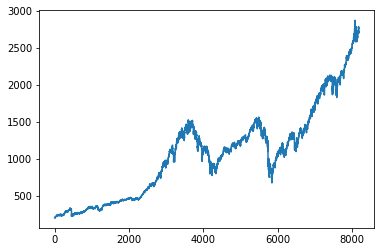

In [3]:
if not executing_on_colab:
    dataset_path = "datasets/spx.csv"
sp500 = pd.read_csv(dataset_path)
sp500.head()
plt.plot(sp500['close'])
plt.show()

In [ ]:
dates = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in sp500['Date']]
dates = mdates.drange(dates[0], dates[-1], datetime.timedelta(days=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(dates, sp500['Close'])
plt.gcf().autofmt_xdate()
plt.show()

In [4]:
data = sp500['close'].to_numpy()
data = torch.from_numpy(data).to(torch.float32)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 - Train MAE 807.043212890625 - Test MAE 1682.6114501953125
loss 797.115
loss 358.883
loss 404.503
loss 399.701


 10%|█         | 1/10 [00:08<01:13,  8.18s/it]

Epoch 1 - Train MAE 397.0794982910156 - Test MAE 834.8780517578125
loss 454.411
loss 386.782
loss 435.217
loss 388.377


 20%|██        | 2/10 [00:13<00:49,  6.23s/it]

Epoch 2 - Train MAE 397.4472961425781 - Test MAE 927.6739501953125
loss 362.260
loss 379.082
loss 372.388
loss 420.584


 30%|███       | 3/10 [00:17<00:39,  5.63s/it]

Epoch 3 - Train MAE 396.9698181152344 - Test MAE 856.3637084960938
loss 400.835
loss 420.973
loss 357.728
loss 372.349


 40%|████      | 4/10 [00:22<00:32,  5.34s/it]

Epoch 4 - Train MAE 401.3985290527344 - Test MAE 768.1372680664062
loss 388.018
loss 419.030
loss 361.002
loss 366.933


 50%|█████     | 5/10 [00:27<00:26,  5.21s/it]

Epoch 5 - Train MAE 397.101318359375 - Test MAE 894.1909790039062
loss 421.969
loss 421.990
loss 402.404
loss 420.812


 60%|██████    | 6/10 [00:32<00:20,  5.12s/it]

Epoch 6 - Train MAE 397.0581970214844 - Test MAE 844.2147216796875
loss 431.737
loss 404.076
loss 423.467
loss 452.959


 70%|███████   | 7/10 [00:37<00:15,  5.05s/it]

Epoch 7 - Train MAE 397.84832763671875 - Test MAE 816.4898071289062
loss 407.744
loss 371.833
loss 398.696
loss 394.033


 80%|████████  | 8/10 [00:42<00:10,  5.00s/it]

Epoch 8 - Train MAE 400.49346923828125 - Test MAE 775.1622924804688
loss 377.370
loss 427.252
loss 393.622
loss 440.899


 90%|█████████ | 9/10 [00:47<00:04,  4.98s/it]

Epoch 9 - Train MAE 398.6094970703125 - Test MAE 809.2645263671875
loss 403.750
loss 392.655
loss 376.359
loss 418.400


100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


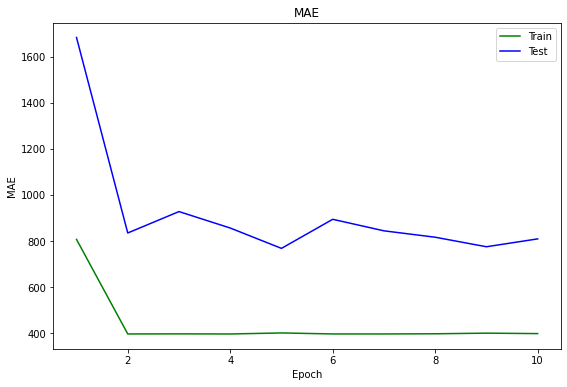

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
learning_rate = 0.01
epochs = 10
window_len = 7
output_len = 1
trainset = data[0:int(len(data) * 0.7)]
testset = data[int(len(data) * 0.7):]
train_dataset = StockDatasetSW(trainset, window_len, output_len)
test_dataset = StockDatasetSW(testset, window_len, output_len)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = Transformer(seq_len=window_len, num_encoder=6, input_size=1, embed_dim=512, num_heads=1, feedforward_dim=1024).to(device)
loss_fun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_maes = []
test_maes = []

for e in tqdm(range(epochs)):
    model.eval()
    
    train_mae = eval(model, train_dl, device)
    test_mae = eval(model, test_dl, device)
    train_maes.append(train_mae.cpu())
    test_maes.append(test_mae.cpu())
    
    print(f"Epoch {e} - Train MAE {train_mae} - Test MAE {test_mae}")
    
    model.train()
    for i, (seq, trg) in enumerate(train_dl):
        seq, trg = seq.to(device), trg.to(device)
        optimizer.zero_grad()
        seq_mask = torch.triu(torch.ones(window_len, window_len) * float('-inf'), diagonal=1).to(device)
        out = model(seq, seq_mask)
        loss = loss_fun(out, trg)
        if i % 50 == 0:
            print(f'loss {loss.cpu().item():.3f}')
        loss.backward()
        optimizer.step()

plot_scores(train_maes, test_maes)